# Fit atmosphere parameters including clouds  using wavelet decomposition as input¶

- author Sylvie Dagoret-Campagne

- creation date August 19th 2020 : remove Rayleigh, add Linear (No reg) fit, mag or no mag fit


In [680]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [681]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [682]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [683]:
import libatmscattering as atm

# Input files : wavelet decomposition coefficients

In [684]:
all_files=["lsst_atm_10year_wavelets_dataset1_cld.fits",
           "lsst_atm_10year_wavelets_dataset2_cld.fits",
           "lsst_atm_10year_wavelets_dataset3_cld.fits",
           "lsst_atm_10year_wavelets_dataset4_cld.fits",
           "lsst_atm_10year_wavelets_dataset5_cld.fits",
           "lsst_atm_10year_wavelets_dataset6_cld.fits",
           "lsst_atm_10year_wavelets_dataset7_cld.fits",
           "lsst_atm_10year_wavelets_dataset8_cld.fits",
           "lsst_atm_10year_wavelets_dataset9_cld.fits"]

### Level of decomposition

- ilevel : from 1 to 9

In [685]:
ilevel=2
ilevel_label="wavelet decomp level {}".format(ilevel)

In [686]:
input_file=all_files[ilevel]

In [687]:
hdu = fits.open(input_file)

In [688]:
hdr=hdu[0].header
data=hdu[0].data

In [689]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   20                                                  
NAXIS2  =                 3650                                                  
NBATMSIM=                 3650                                                  
ID_NUM  =                    0                                                  
ID_YEAR =                    1                                                  
ID_AM   =                    2                                                  
ID_VAOD =                    3                                                  
ID_PWV  =                    4                                                  
ID_O3   =                    5                                                  
ID_CLD  =                   

In [690]:
NbAtmSimul=hdr['NBATMSIM']
idx_out_num=hdr['ID_NUM']
idx_out_year=hdr['ID_YEAR']
idx_out_am=hdr['ID_AM']
idx_out_vaod=hdr['ID_VAOD']
idx_out_pwv=hdr['ID_PWV']
idx_out_o3=hdr['ID_O3']
idx_out_cld=hdr['ID_CLD']
idx_out_res=hdr['ID_RES']

In [691]:
num=data[0:,idx_out_num]
year=data[0:,idx_out_year]
airmass=data[0:,idx_out_year]
vaod=data[0:,idx_out_vaod] # vertical aerosol depth
pwv=data[0:,idx_out_pwv]   # precipitable water vapor (mm)
o3=data[0:,idx_out_o3]     # ozone
cld=data[0:,idx_out_cld]   # clouds (not used)

Text(0.5, 0, 'cloud optical depth ')

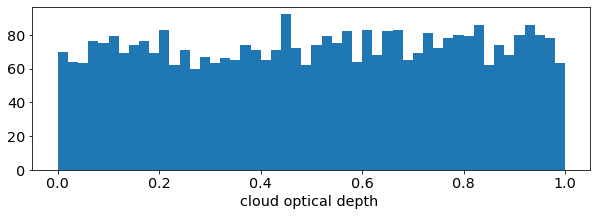

In [692]:
fig=plt.figure(figsize=(10,3))

ax = fig.add_subplot(111)
plt.hist(cld,bins=50,label="in data")
#ax.set_yscale('log')
ax.set_xlabel("cloud optical depth ")

In [693]:
coeff=data[:,idx_out_res:]

In [694]:
N=coeff.shape[1]
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

Text(0, 0.5, 'coefficient value')

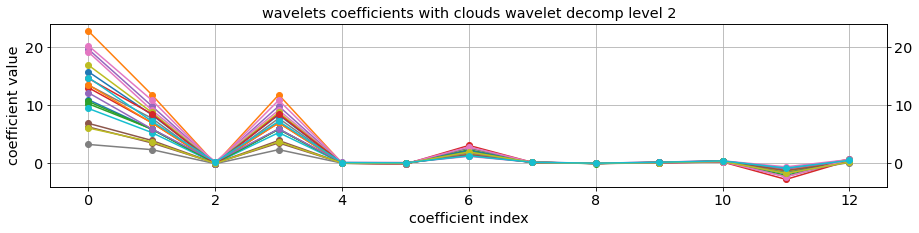

In [695]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
for idx in np.arange(20):
    ax.plot(coeff[idx,:],"o-")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax.grid()
ax.set_title("wavelets coefficients with clouds "+ ilevel_label)
ax.set_xlabel("coefficient index")
ax.set_ylabel("coefficient value")

# Prepare data

In [696]:
vaodarr=vaod[:,np.newaxis]
pwvarr=pwv[:,np.newaxis]
o3arr=o3[:,np.newaxis]
cldarr=cld[:,np.newaxis]

### Y is concatenate VAOD,PWV, Ozone, Clouds

In [697]:
Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)

###  X are the wavelets coefficients

In [698]:
X=coeff

## Splitting

In [699]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [700]:
X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

## Scaling

In [701]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [702]:
FLAG_SCALING=True

In [703]:
scaler_X.fit(X_train) 
scaler_Y.fit(Y_train) 

StandardScaler()

In [704]:
scaler_X.mean_.shape

(13,)

In [705]:
scaler_X.scale_.shape

(13,)

In [706]:
scaler_Y.mean_.shape

(4,)

In [707]:
scaler_Y.scale_.shape

(4,)

In [708]:
X_train_scaled = scaler_X.transform(X_train)
Y_train_scaled = scaler_Y.transform(Y_train)    
X_val_scaled = scaler_X.transform(X_val)
Y_val_scaled = scaler_Y.transform(Y_val)
X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)

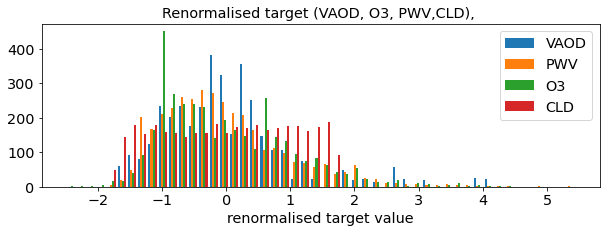

In [709]:
fig=plt.figure(figsize=(10,3))
ax = fig.add_subplot(111)
ax.hist(np.concatenate((Y_train_scaled,Y_val_scaled,Y_test_scaled),axis=0),bins=50,
        label=["VAOD","PWV","O3","CLD"])
ax.set_title("Renormalised target (VAOD, O3, PWV,CLD), ")
ax.set_xlabel("renormalised target value")
ax.legend()

## Linear regression model

In [710]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [711]:
reg = linear_model.LinearRegression()

In [712]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [713]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets

if FLAG_SCALING:
    regr.fit(X_train_scaled, Y_train_scaled)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test_scaled)
else:
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)



# The coefficients
print('Coefficients: \n', regr.coef_)
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f'% r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))


Coefficients: 
 [[-3.55423904e+02  4.58807948e+01  5.69202441e+01  4.58807948e+01
   6.13012138e+01  5.68209908e+00 -3.55141378e+01 -3.98972123e+01
  -5.13104043e+01 -3.40351794e+01 -1.23805375e+01 -1.90073899e+01
   2.75881293e+02]
 [-3.34380182e+00  1.59132746e+00  1.73980888e+00  1.59132746e+00
   9.01410176e-02  3.34168003e+00 -5.69484553e+00 -2.76388958e-01
  -6.43317935e-01 -3.14381127e+00 -3.26306955e+00 -3.89636133e+00
   2.09809932e+00]
 [-2.18394389e-01 -2.64059831e-03  8.20500121e-01 -2.64059831e-03
  -6.86677195e-01 -1.62155554e+00  2.22450482e+00  1.71170234e+00
  -2.06482575e+00  1.03265609e+00  1.20797655e+00  1.60567866e+00
  -5.32098381e-01]
 [ 2.72361125e+01 -3.38733110e+00 -4.18224741e+00 -3.38733110e+00
  -4.53035113e+00 -4.17488353e-01  2.61882849e+00  2.93749889e+00
   3.79703400e+00  2.51096886e+00  9.12644433e-01  1.40103630e+00
  -2.03609297e+01]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


# Linear Regression with Ridge

In [714]:
from sklearn import linear_model
regr_ridge = linear_model.Ridge(alpha=1e-5)

In [715]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_ridge.fit(X_train_scaled, Y_train_scaled)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test_scaled)
else:
    regr_ridge.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr_ridge.predict(X_test)

print(regr_ridge)

# The coefficients
print('Coefficients: \n', regr_ridge.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred))
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred))

Ridge(alpha=1e-05)
Coefficients: 
 [[  5.59119883 -10.45718928   7.65283386 -10.45718926  -0.70830404
   -0.49075889   2.49301476  -0.79137158  -2.70654304  -4.85895095
    0.75049239   0.74694836  14.46950171]
 [  0.8099589    1.1124151    1.42988938   1.1124151    0.41901853
    2.99601185  -4.93148692  -0.46128684  -0.69658837  -2.78485413
   -2.86645814  -3.40552971  -1.35896399]
 [ -0.19338556  -0.38698216   0.60494226  -0.38698216  -0.55349328
   -1.39613019   1.94318828   1.64090909  -2.01680403   1.07530902
    0.96756681   1.33369685   0.3069892 ]
 [ -0.08909734   0.95309797  -0.43167432   0.95309796   0.04450086
    0.02789928  -0.22556242   0.0470857    0.16268522   0.29255764
   -0.05291733  -0.05669904  -0.73807503]]
Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


## Tune hyper parameter with Ridge

In [716]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, -1, n_alphas)
all_MSE = []

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    
    if FLAG_SCALING:
    
        ridge.fit(X_train_scaled,Y_train_scaled)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        ridge.fit(X_train,Y_train)
        coefs.append(ridge.coef_)
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred = ridge.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE result
    all_MSE.append(MSE)
    
allcoefs=np.array(coefs)
alphas=np.array(alphas)
all_MSE=np.array(all_MSE)

<Figure size 1080x1080 with 0 Axes>

In [717]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [718]:
alpha_ridge_min=alphas[idx_min]
alpha_ridge_min

1e-10

In [719]:
ilevel_label

'wavelet decomp level 2'

In [720]:
RIDGE_MSE_THRES=[
    1e-7,
    0.016,      #level 1
    3e-6,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

0.00017426333860096508

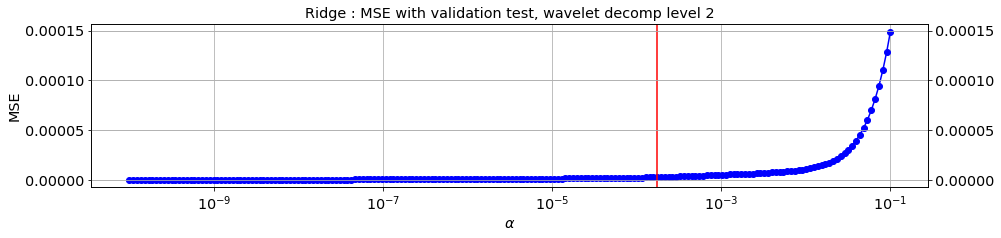

In [721]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")

#idx_min=np.where(all_MSE<RIDGE_MSE_THRES[ilevel])[0][-1]
idx_min=np.where(all_MSE<RIDGE_MSE_THRES[ilevel])[0][-1]

alpha_ridge=alphas[idx_min]
ax.axvline(x=alpha_ridge,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("Ridge : MSE with validation test, "+ilevel_label)
ax.grid()
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()
alpha_ridge

### Display results

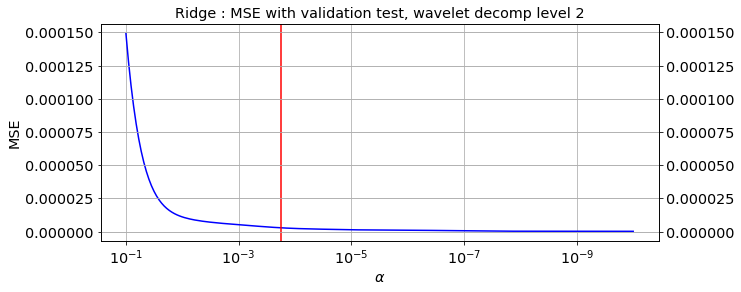

In [722]:
fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
ax.axvline(x=alpha_ridge,color='red')
#ax.set_yscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.grid()
ax.set_title("Ridge : MSE with validation test, "+ilevel_label)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

In [723]:
alpha_ridge_sel=alpha_ridge
alpha_ridge_label="($\\alpha$ = {:1.3e})".format(alpha_ridge_sel)

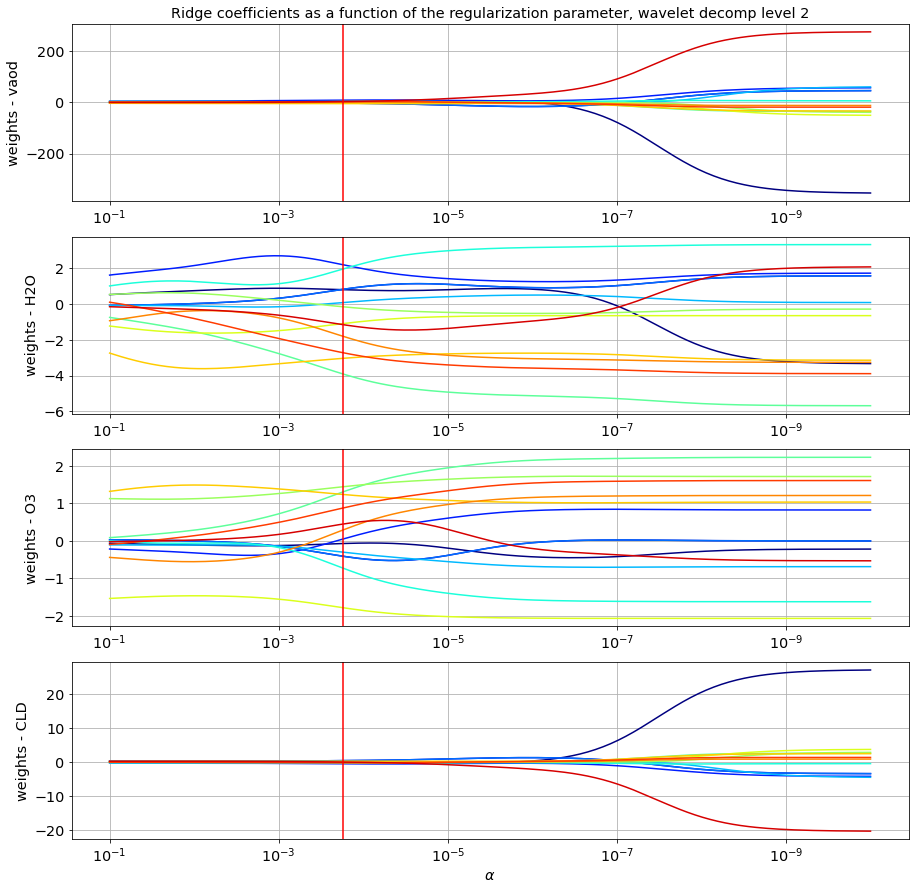

In [724]:
fig=plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs.shape[2]):
    ax1.plot(alphas, allcoefs[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.axvline(x=alpha_ridge_sel,color='red')
ax1.set_title('Ridge coefficients as a function of the regularization parameter, '+ ilevel_label)

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax2.plot(alphas, allcoefs[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.axvline(x=alpha_ridge_sel,color='red')
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax3.plot(alphas, allcoefs[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.axvline(x=alpha_ridge_sel,color='red')
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax1)
for idx in np.arange(allcoefs.shape[2]):
    ax4.plot(alphas, allcoefs[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
#ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.set_xlim(ax4.get_xlim())  # reverse axis
ax4.axvline(x=alpha_ridge_sel,color='red')
ax4.grid(True)


plt.xlabel('$\\alpha$')
plt.axis('tight')
plt.show()

# Linear Regression with Lasso

In [725]:
from sklearn import linear_model

In [726]:
regr_lasso = linear_model.Lasso(alpha=1e-5)

In [727]:
# Train the model using the training sets

if FLAG_SCALING:
    regr_lasso.fit(X_train_scaled, Y_train_scaled)
    Y_pred_lasso = regr_lasso.predict(X_test_scaled)
    
else:
    regr_lasso.fit(X_train, Y_train)
    Y_pred_lasso = regr_lasso.predict(X_test)
    
    
# The coefficients
print('Coefficients: \n', regr_lasso.coef_)

if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_lasso))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_lasso))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_lasso))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_lasso))

Coefficients: 
 [[ 0.25103486 -0.32839784  2.26362633  0.0453562  -1.33477962  0.62558192
   1.96280745  0.02112928  0.51118411 -0.76191308  0.24921843  0.48950385
  -0.63286512]
 [ 0.13376789 -0.07815873  0.24180486  0.00270147 -0.09641185 -0.63173334
   0.57113468  0.90322345 -0.64531667 -0.65499     0.04618283  0.54578051
  -0.25123376]
 [ 0.0558645   0.01425183  0.29099982  0.          0.05684816  0.01245121
   0.06988516  0.84227707 -1.7350054   1.11954151 -0.71429219  0.10338943
  -0.09411609]
 [ 0.99658559  0.00763239 -0.08357909  0.          0.04604574 -0.04009818
  -0.09961739  0.01131795 -0.0402923  -0.00817603 -0.0048348   0.01931692
   0.03098632]]
Mean squared error: 0.00423
Coefficient of determination: 0.99588
Explained variance: 0.99588


/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.352493216997969, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.013339625253098, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23163449509568174, tolerance: 0.2190000000000001
  positive)


In [728]:
fig=plt.figure(figsize=(15,15))
##############################################################################
# Compute paths

n_alphas = 20
alphas = np.logspace(-10, -1, n_alphas)

all_MSE = []
coefs = []
coefs_noconst = []

for a in alphas:
    # fit with intercept
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True,max_iter=1000)
    # fit without intercept
    lasso2 = linear_model.Lasso(alpha=a, fit_intercept=False,max_iter=1000)
        
    if FLAG_SCALING:
        lasso.fit(X_train_scaled,Y_train_scaled);
        lasso2.fit(X_train_scaled,Y_train_scaled);
    else:
        lasso.fit(X_train,Y_train);
        lasso2.fit(X_train,Y_train);
            
    # book coefficients        
    coefs.append(lasso.coef_) 
    coefs_noconst.append(lasso2.coef_)
    
    # calculate metric
    # Make predictions using the testing set
    
    if FLAG_SCALING:
        Y_pred = lasso.predict(X_val_scaled)
        MSE=mean_squared_error(Y_val_scaled, Y_pred)
    else:
        Y_pred = lasso.predict(X_val)
        MSE=mean_squared_error(Y_val, Y_pred)
        
    # book MSE    
    all_MSE.append(MSE)

alphas=np.array(alphas)
allcoefs=np.array(coefs)
allcoefs2=np.array(coefs_noconst)
all_MSE=np.array(all_MSE)

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.39765542001493, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.065363884102597, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.397655420015527, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want t

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.394805361899909, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.061917328850778, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.394805361900511, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1432057894491874, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.197939400680201, tolerance: 0.2190000000000001
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.3512712116589, tolerance: 0.2189999999999995
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to 

<Figure size 1080x1080 with 0 Axes>

In [729]:
idx_min=np.where(all_MSE==all_MSE.min())[0][0]

In [730]:
alpha_lasso_min=alphas[idx_min]
alpha_lasso_min

1.623776739188721e-05

In [731]:
ilevel_label

'wavelet decomp level 2'

In [732]:
LASSO_MSE_THRES=[
    1e-7,
    0.05,      #level 1
    4e-3,      #level 2 
    1e-7,      #level 3 
    1e-7,      #level 4
    1e-7,      #level 5
    1e-7,      #level 6
    1e-7,      #level 7
    1e-7,      #level 8
    1e-7,      #level 9
]

0.0004281332398719387

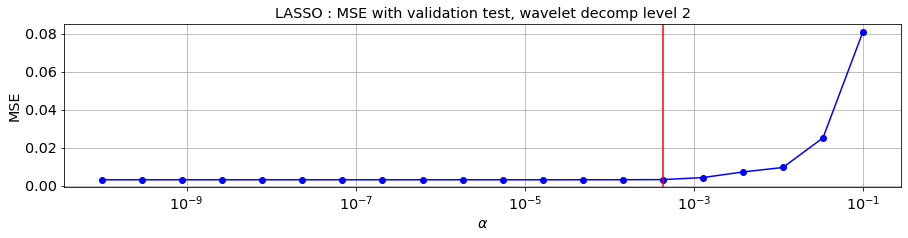

In [733]:
fig=plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-o')
ax.set_xscale("log")

#idx_min=np.where(all_MSE==all_MSE.min())[0][0]
idx_min=np.where(all_MSE<LASSO_MSE_THRES[ilevel])[0][-1]


alpha_lasso=alphas[idx_min]
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test, "+ilevel_label)
ax.grid()
alpha_lasso

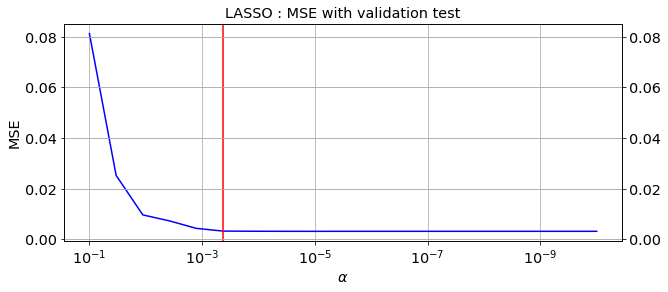

In [734]:
fig=plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(alphas,all_MSE,'b-')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.grid()
ax.axvline(x=alpha_lasso,color='red')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with validation test")
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.grid()

In [735]:
# Final selection
alpha_lasso_sel=alpha_lasso
alpha_lasso_label="( $\\alpha$ = {:1.3e})".format(alpha_lasso_sel)

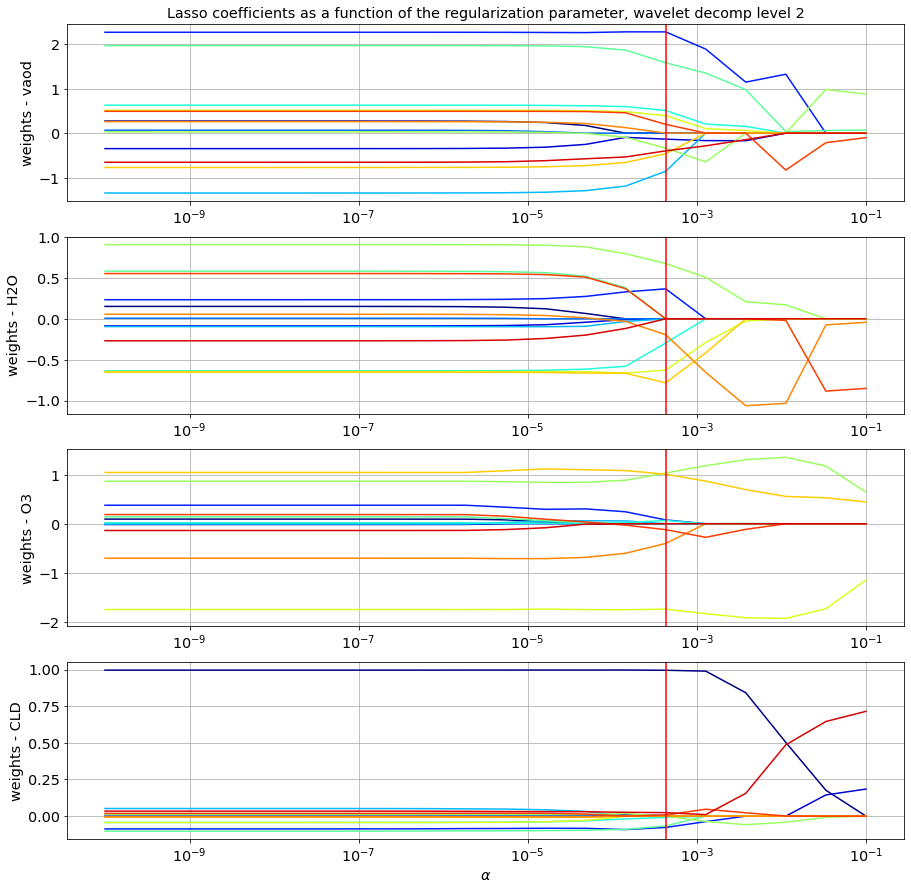

In [736]:
fig=plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(411)
for idx in np.arange(allcoefs2.shape[2]):
    ax1.plot(alphas, allcoefs2[:,0,idx],color=all_colors[idx])
ax1.set_xscale('log')
ax1.set_ylabel('weights - vaod')
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.grid(True)
ax1.axvline(x=alpha_lasso_sel,color='red')
ax1.set_title('Lasso coefficients as a function of the regularization parameter, '+ilevel_label)

ax2 = fig.add_subplot(412,sharex=ax1)
for idx in np.arange(allcoefs2.shape[2]):
    ax2.plot(alphas, allcoefs2[:,1,idx],color=all_colors[idx])
ax2.set_xscale('log')
ax2.set_ylabel('weights - H2O')
ax2.set_xlim(ax2.get_xlim()[::-1])  # reverse axis
ax2.axvline(x=alpha_lasso_sel,color='red')
ax2.grid(True)

ax3= fig.add_subplot(413,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax3.plot(alphas, allcoefs2[:,2,idx],color=all_colors[idx])
ax3.set_ylabel('weights - O3')
ax3.set_xscale('log')
ax3.set_xlim(ax3.get_xlim()[::-1])  # reverse axis
ax3.axvline(x=alpha_lasso_sel,color='red')
ax3.grid(True)

ax4= fig.add_subplot(414,sharex=ax2)
for idx in np.arange(allcoefs2.shape[2]):
    ax4.plot(alphas, allcoefs2[:,3,idx],color=all_colors[idx])
ax4.set_ylabel('weights - CLD')
ax4.set_xscale('log')
ax4.set_xlim(ax4.get_xlim()[::-1])  # reverse axis
ax4.axvline(x=alpha_lasso_sel,color='red')
ax4.grid(True)

plt.xlabel('$\\alpha$')
plt.axis('tight')
plt.show()

# Verification with test  set

## Check learning curves

In [737]:
nb_tot_test=len(Y_test)

In [738]:
nsamples=np.arange(10,nb_tot_test,10)

### Leraning curves for linear regression

In [739]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [740]:
count=0
for n in nsamples:
    
    regr = linear_model.LinearRegression(fit_intercept=True)
  
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    regr.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = regr.predict(X_train_cut)
    Y_pred_test  = regr.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

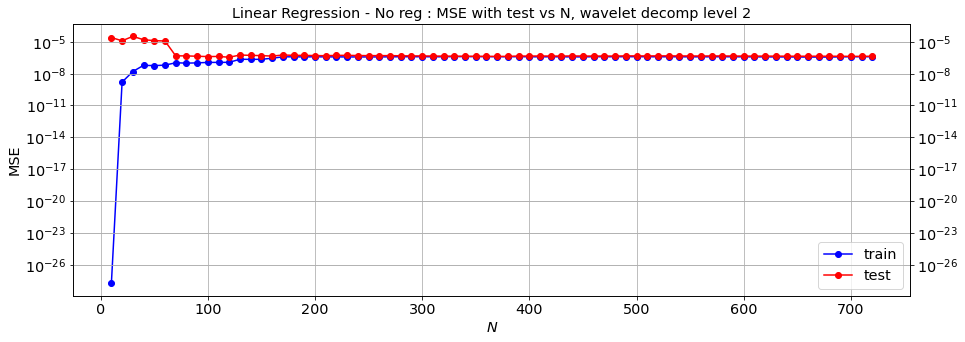

In [741]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("Linear Regression - No reg : MSE with test vs N, "+ilevel_label)
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Ridge

In [742]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [743]:
alpha_ridge

0.00017426333860096508

In [744]:
alpha_ridge_min

1e-10

In [745]:
count=0
for n in nsamples:
    

    ridge = linear_model.Ridge(alpha=alpha_ridge, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    ridge.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = ridge.predict(X_train_cut)
    Y_pred_test  = ridge.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

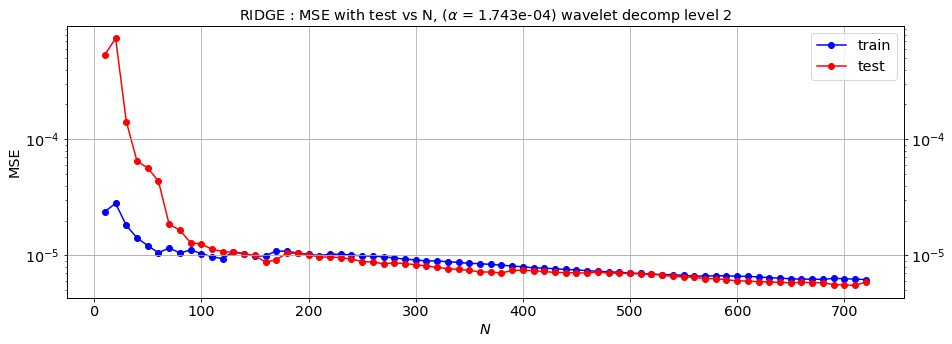

In [746]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("RIDGE : MSE with test vs N, "+ alpha_ridge_label+" "+ ilevel_label)
ax.grid()
#ax.set_ylim(1e-6,1e-2)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

### Learning curves for Lasso

In [747]:
all_MSE_train=np.zeros(len(nsamples))
all_MSE_test=np.zeros(len(nsamples))

In [748]:
alpha_lasso

0.0004281332398719387

In [749]:
alpha_lasso_min

1.623776739188721e-05

In [750]:
alpha_lasso_0=alpha_lasso_min

In [751]:
count=0
for n in nsamples:
    

    lasso = linear_model.Lasso(alpha=alpha_lasso_0, fit_intercept=True)
    
    if FLAG_SCALING:       
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    else:
        X_train_cut=X_train[:n,:]
        Y_train_cut=Y_train[:n,:]
        X_test_cut=X_test[:n,:]
        Y_test_cut=Y_test[:n,:]  
        
    lasso.fit(X_train_cut,Y_train_cut)
    
    
    # calculate metric
    # Make predictions using the testing set
    Y_pred_train = lasso.predict(X_train_cut)
    Y_pred_test  = lasso.predict(X_test_cut)
    
    MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
    MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

    all_MSE_train[count]=MSE_train
    all_MSE_test[count]=MSE_test
    
    count+=1
    # end of loop
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028869751851222866, tolerance: 0.0009938346153402725
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004101642641853123, tolerance: 0.0003225237752955068
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013337660520083942, tolerance: 0.0007725971819792289
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03429937094084501, tolerance: 0.026507867217135914
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.589672440216516, tolerance: 0.0186785888244646
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5230530744314826, tolerance: 0.02931746772025968
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.057258350931826414, tolerance: 0.040956285720598805
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.53975405649319, tolerance: 0.035980692864605236
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8523243437718161, tolerance: 0.04851746351435983
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might w

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1039051582366863, tolerance: 0.06190236427327882
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07701563986809565, tolerance: 0.05633257697367328
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.486532238425992, tolerance: 0.05196541205280371
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might wan

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.078349831528414, tolerance: 0.0630867071227337
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.304383674122368, tolerance: 0.07182301991550365
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09271140391451459, tolerance: 0.07035698473102316
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want 

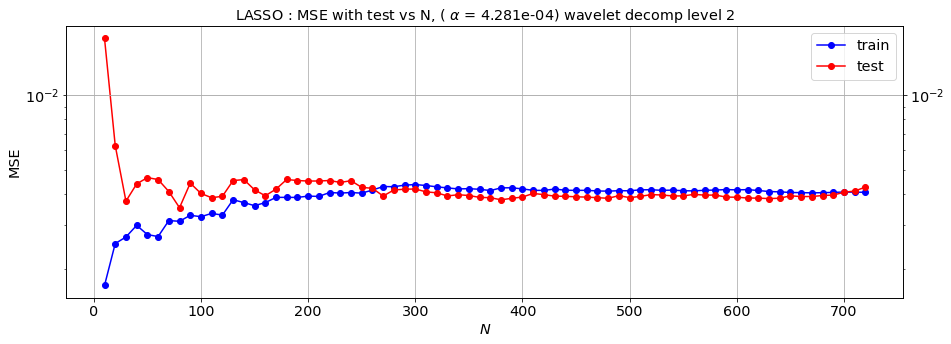

In [752]:
fig=plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
ax.plot(nsamples, all_MSE_train,'b-o',label="train")
ax.plot(nsamples, all_MSE_test,'r-o',label="test")
ax.legend()
ax.grid()
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")
ax.set_title("LASSO : MSE with test vs N, "+ alpha_lasso_label+ " "+ ilevel_label)
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_yscale("log")
ax1.grid()

# Final

# No regularisation

In [753]:
regr = linear_model.LinearRegression(fit_intercept=True)
    
if FLAG_SCALING:           
    regr.fit(X_train_scaled,Y_train_scaled)
else:
    regr.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = regr.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = regr.predict(X_test)
    DY=Y_pred_test-Y_test
    

In [754]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


Text(0.5, 1.05, 'Linear Regression - No reg (with cloud) wavelet decomp level 2')

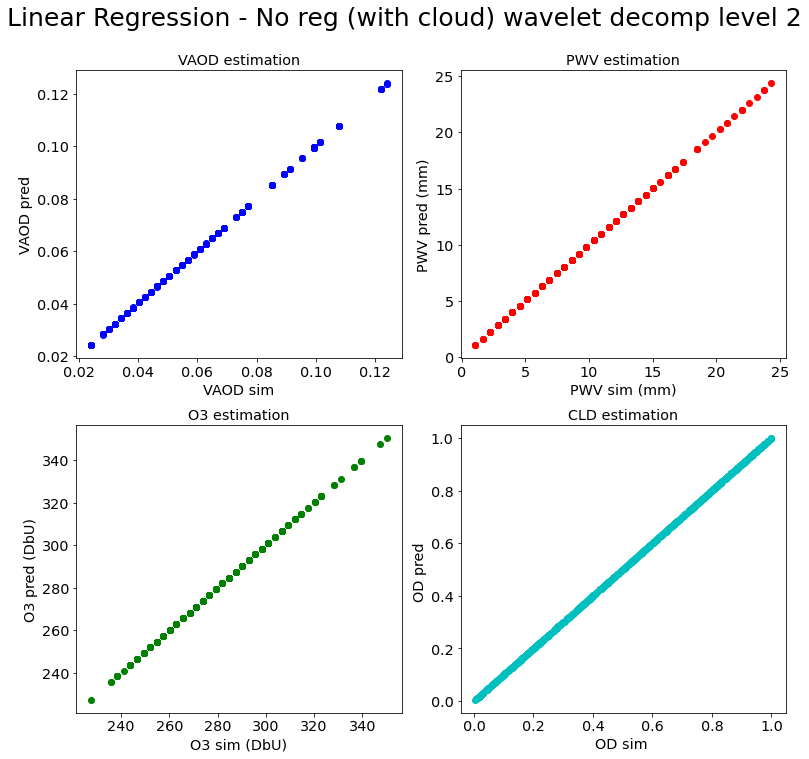

In [755]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")


ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (DbU)")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],Y_pred_test_inv[:,3],'co')
ax.set_xlabel("OD sim ")
ax.set_ylabel("OD pred ")
ax.set_title("CLD estimation")


plt.tight_layout()
plt.suptitle("Linear Regression - No reg (with cloud) "+ilevel_label,Y=1.05,fontsize=25)

Text(0.5, 1.05, 'Linear Regression + No Reg (with cloud), wavelet decomp level 2')

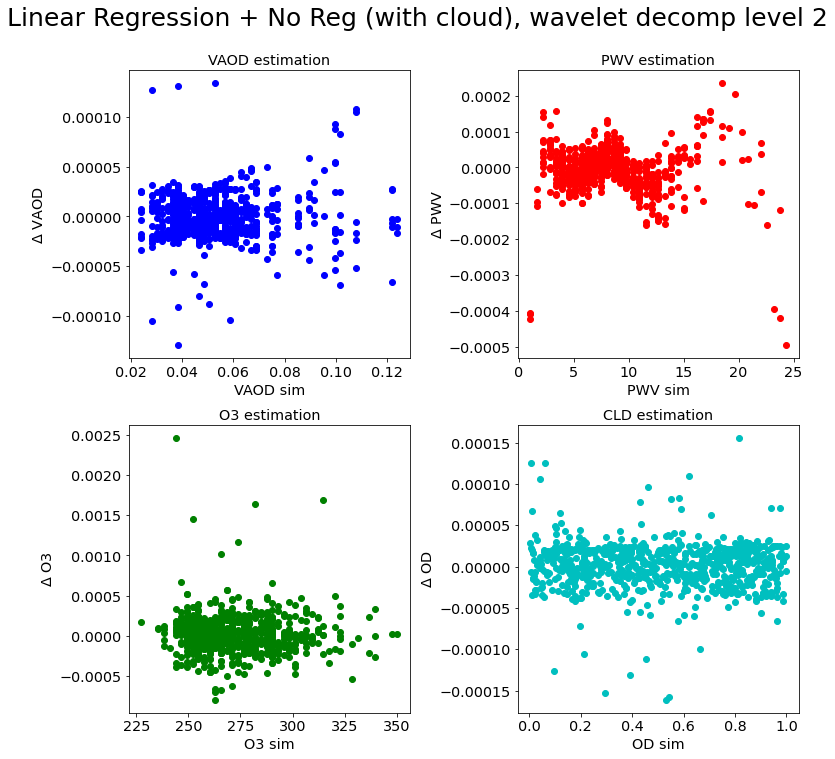

In [756]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
#ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],Y_pred_test_inv[:,3]-Y_test[:,3],'co')
ax.set_xlabel("OD sim")
ax.set_ylabel("$\\Delta$ OD")
ax.set_title("CLD estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + No Reg (with cloud), "+ilevel_label,Y=1.05,fontsize=25)

Text(0.5, 1.05, 'Linear Regression + No Reg reg, (with cloud), wavelet decomp level 2')

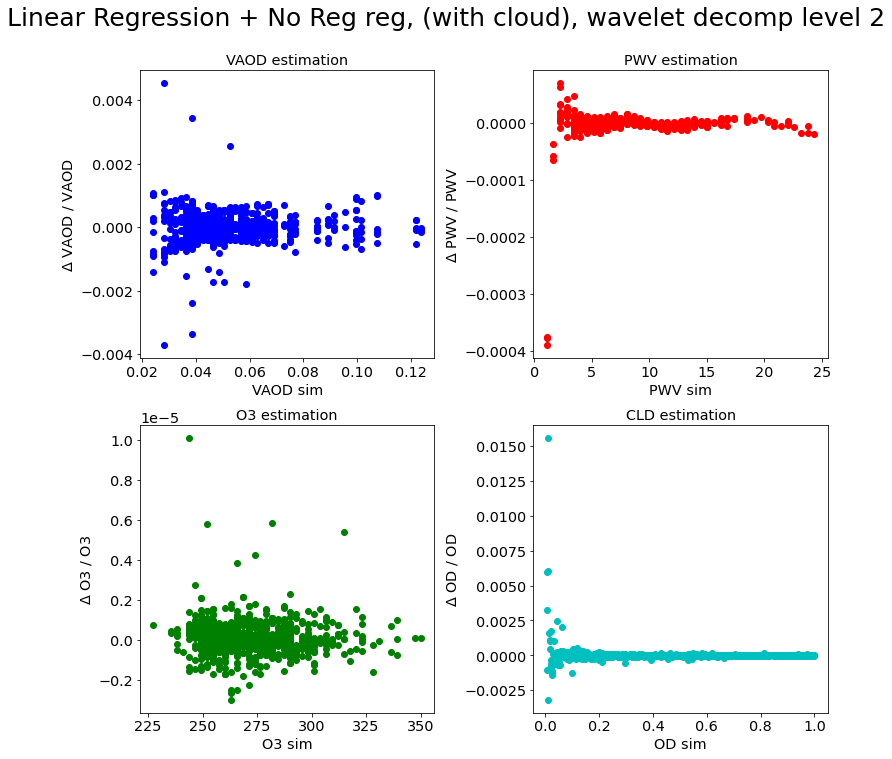

In [757]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")


ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],(Y_pred_test_inv[:,3]-Y_test[:,3])/Y_test[:,3],'co')
ax.set_xlabel("OD sim")
ax.set_ylabel("$\\Delta$ OD / OD")
ax.set_title("CLD estimation")


plt.tight_layout()
plt.suptitle("Linear Regression + No Reg reg, (with cloud), "+ilevel_label,Y=1.05,fontsize=25)

## Ridge

In [758]:
ridge = linear_model.Ridge(alpha=alpha_ridge_min, fit_intercept=True)
    
if FLAG_SCALING:           
    ridge.fit(X_train_scaled,Y_train_scaled)
else:
    ridge.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = ridge.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = ridge.predict(X_test)
    DY=Y_pred_test-Y_test
    
    


In [759]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00000
Coefficient of determination: 1.00000
Explained variance: 1.00000


In [760]:
ridge.coef_

array([[-3.54233705e+02,  4.56350388e+01,  5.66704141e+01,
         4.56444279e+01,  6.02609133e+01,  5.74346248e+00,
        -3.54986657e+01, -3.92548963e+01, -5.07286721e+01,
        -3.39824205e+01, -1.23921676e+01, -1.90302973e+01,
         2.75167415e+02],
       [-3.33111396e+00,  1.58861757e+00,  1.73828333e+00,
         1.58969146e+00,  9.15635124e-02,  3.34127792e+00,
        -5.69327683e+00, -2.77208833e-01, -6.43349829e-01,
        -3.14258002e+00, -3.26255145e+00, -3.89553980e+00,
         2.08921867e+00],
       [-2.19215974e-01, -2.14122278e-03,  8.20602587e-01,
        -2.87116295e-03, -6.86679512e-01, -1.62153249e+00,
         2.22440722e+00,  1.71170073e+00, -2.06486626e+00,
         1.03258175e+00,  1.20794275e+00,  1.60562706e+00,
        -5.31512078e-01],
       [ 2.71463133e+01, -3.36882235e+00, -4.16347712e+00,
        -3.36951575e+00, -4.45274252e+00, -4.22044779e-01,
         2.61756366e+00,  2.88957657e+00,  3.75358133e+00,
         2.50694105e+00,  9.13477758e

Text(0.5, 1.05, 'Linear Regression + Ridge reg, (with cloud), wavelet decomp level 2')

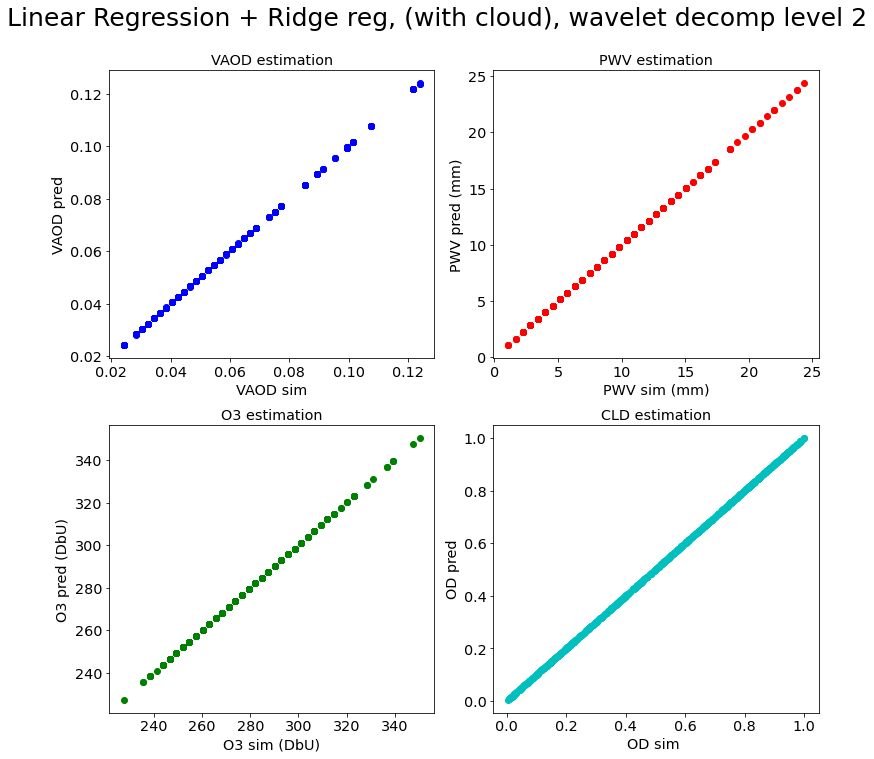

In [761]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")


ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (DbU)")
ax.set_title("O3 estimation")


ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],Y_pred_test_inv[:,3],'co')
ax.set_xlabel("OD sim ")
ax.set_ylabel("OD pred")
ax.set_title("CLD estimation")



plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud), "+ilevel_label,Y=1.05,fontsize=25)

Text(0.5, 1.05, 'Linear Regression + Ridge reg, (with cloud), +ilevel_label')

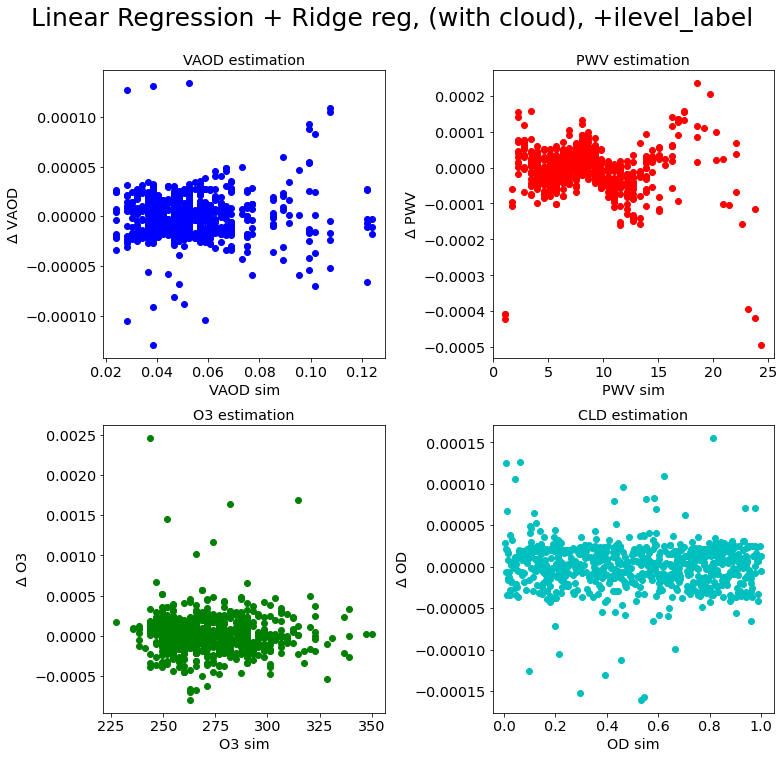

In [762]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
#ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],Y_pred_test_inv[:,3]-Y_test[:,3],'co')
ax.set_xlabel("OD sim")
ax.set_ylabel("$\\Delta$ OD")
ax.set_title("CLD estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud), +ilevel_label",Y=1.05,fontsize=25)

Text(0.5, 1.05, 'Linear Regression + Ridge reg, (with cloud), wavelet decomp level 2')

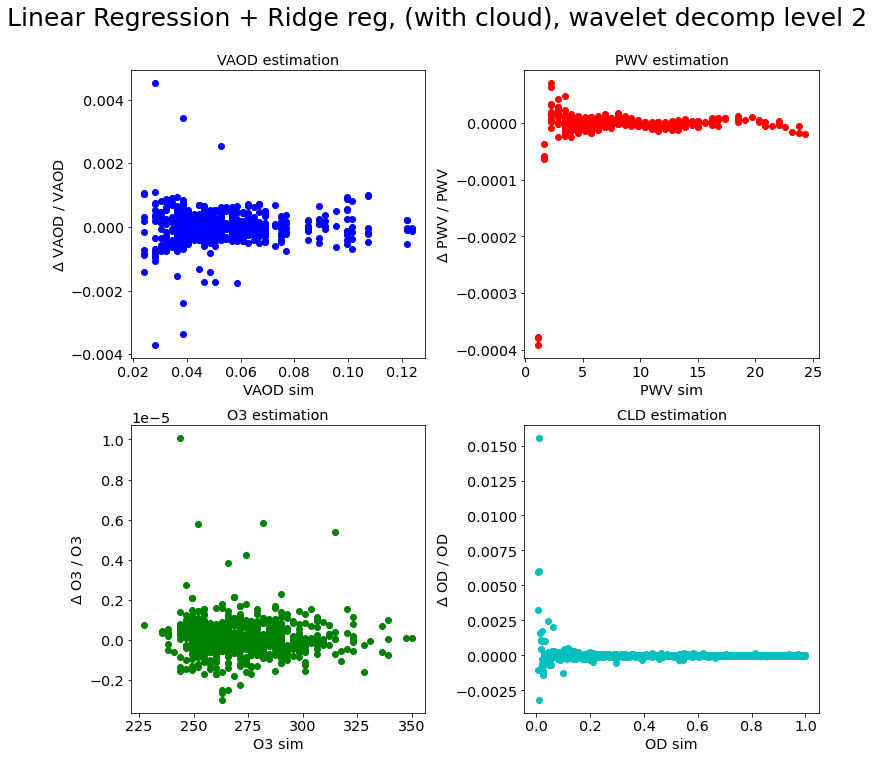

In [763]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],(Y_pred_test_inv[:,3]-Y_test[:,3])/Y_test[:,3],'co')
ax.set_xlabel("OD sim")
ax.set_ylabel("$\\Delta$ OD / OD")
ax.set_title("CLD estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Ridge reg, (with cloud), "+ilevel_label,Y=1.05,fontsize=25)

## Lasso

In [764]:
#lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
lasso = linear_model.Lasso(alpha=alpha_lasso_min, fit_intercept=True)
    
if FLAG_SCALING:           
    lasso.fit(X_train_scaled,Y_train_scaled)
else:
    lasso.fit(X_train,Y_train)
       
    # calculate metric
    # Make predictions using the testing set

if FLAG_SCALING:    
    Y_pred_test  = lasso.predict(X_test_scaled)
    Y_pred_test_inv = scaler_Y.inverse_transform(Y_pred_test)
    DY=Y_pred_test-Y_test_scaled
else:
    Y_pred_test  = lasso.predict(X_test)
    DY=Y_pred_test-Y_test
    
    

/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.325466682914776, tolerance: 0.21899999999999956
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9833019269907357, tolerance: 0.21899999999999992
  positive)
/Users/dagoret/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28170673543458713, tolerance: 0.2190000000000001
  positive)


In [765]:
if FLAG_SCALING:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test_scaled, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test_scaled, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test_scaled, Y_pred_test))
   
else:
    # The mean squared error
    print('Mean squared error: %.5f'% mean_squared_error(Y_test, Y_pred_test))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.5f' % r2_score(Y_test, Y_pred_test))
    # Explained variance : 1 is perfect prediction
    print('Explained variance: %.5f'% explained_variance_score(Y_test, Y_pred_test))

Mean squared error: 0.00423
Coefficient of determination: 0.99588
Explained variance: 0.99588


Text(0.5, 1.05, 'Linear Regression + Lasso reg, (with cloud), wavelet decomp level 2')

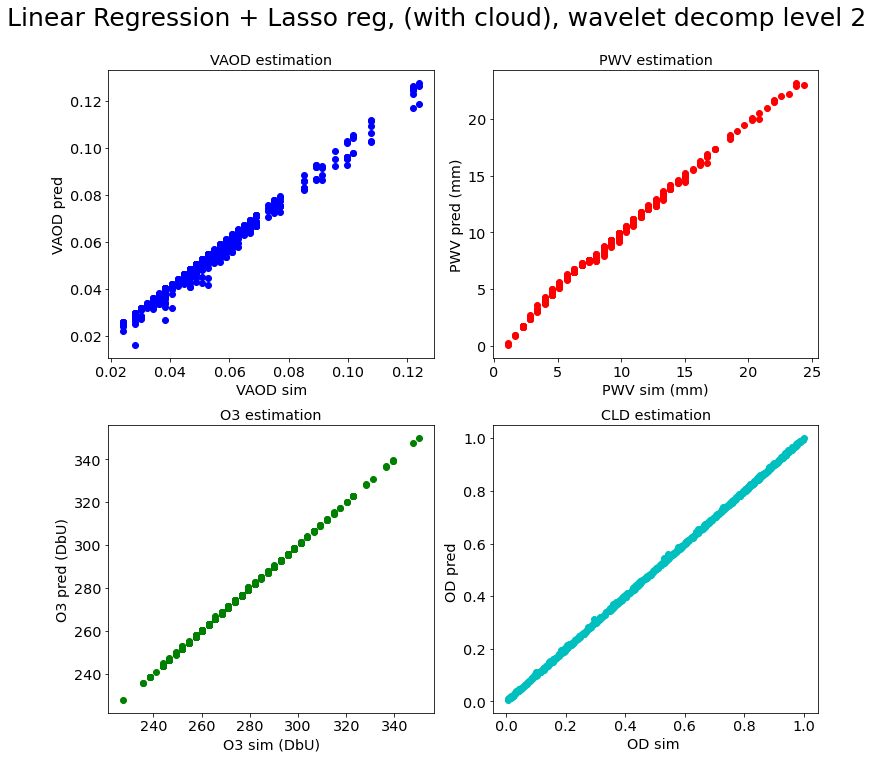

In [766]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("VAOD pred")
ax.set_title("VAOD estimation")

ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1],'ro')
ax.set_xlabel("PWV sim (mm)")
ax.set_ylabel("PWV pred (mm)")
ax.set_title("PWV estimation")

ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2],'go')
ax.set_xlabel("O3 sim (DbU)")
ax.set_ylabel("O3 pred (DbU)")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],Y_pred_test_inv[:,3],'co')
ax.set_xlabel("OD sim ")
ax.set_ylabel("OD pred ")
ax.set_title("CLD estimation")

plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud), "+ilevel_label,Y=1.05,fontsize=25)

Text(0.5, 1.05, 'Linear Regression + Lasso reg, (no cloud), wavelet decomp level 2')

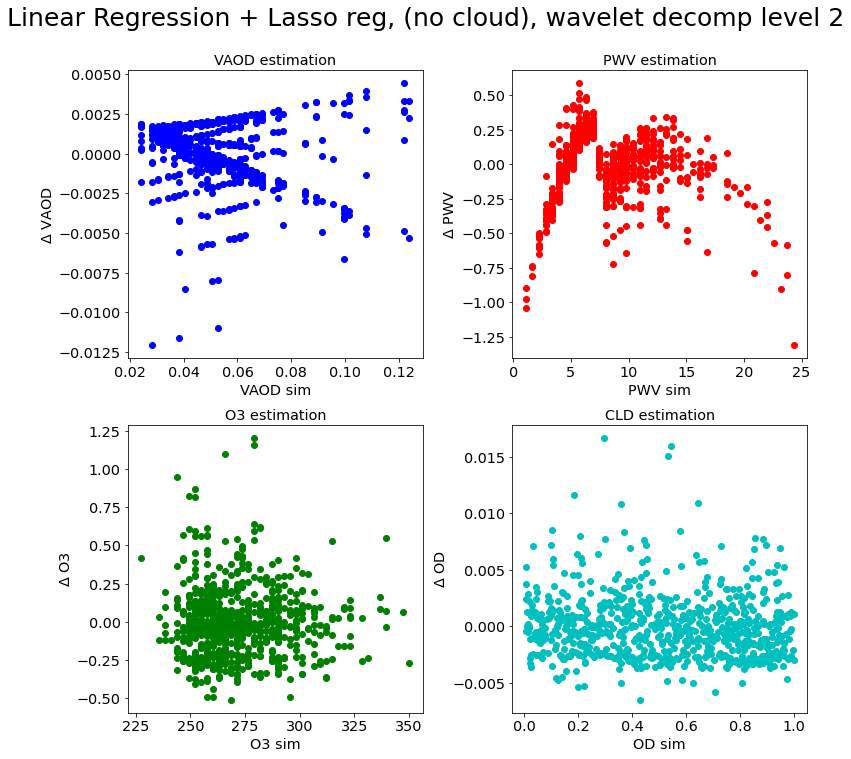

In [767]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],Y_pred_test_inv[:,0]-Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],Y_pred_test_inv[:,1]-Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV")
ax.set_title("PWV estimation")
#ax.set_ylim(-0.002,0.002)


ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],Y_pred_test_inv[:,2]-Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],Y_pred_test_inv[:,3]-Y_test[:,3],'co')
ax.set_xlabel("OD sim")
ax.set_ylabel("$\\Delta$ OD")
ax.set_title("CLD estimation")


plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (no cloud), "+ilevel_label,Y=1.05,fontsize=25)

Text(0.5, 1.05, 'Linear Regression + Lasso reg, (with cloud), wavelet decomp level 2')

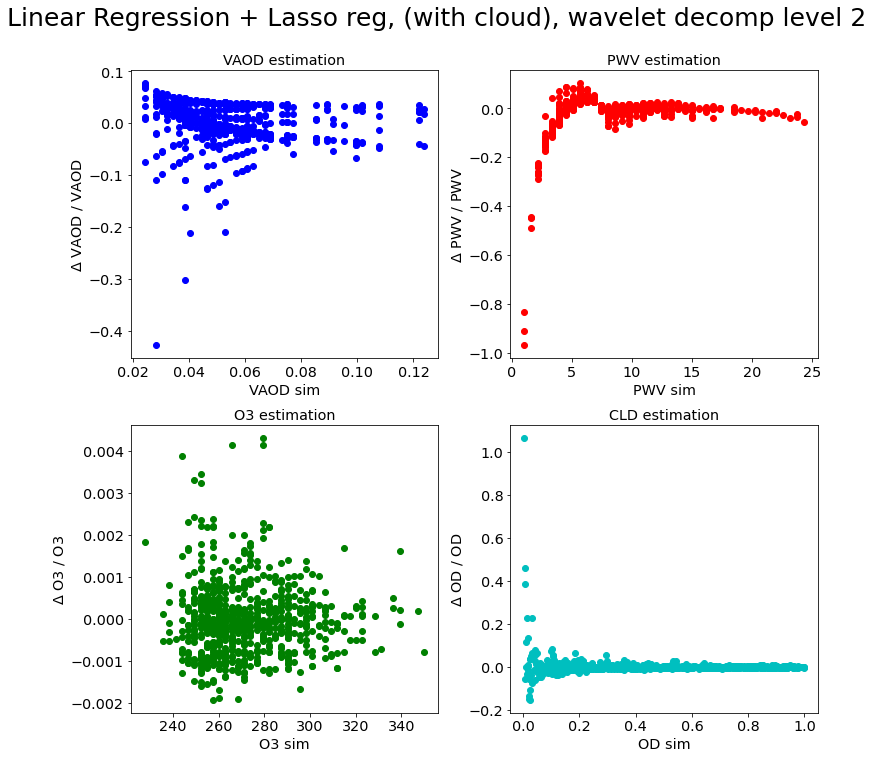

In [768]:
fig=plt.figure(figsize=(11,10))
ax = fig.add_subplot(221)
ax.plot(Y_test[:,0],(Y_pred_test_inv[:,0]-Y_test[:,0])/Y_test[:,0],'bo')
ax.set_xlabel("VAOD sim")
ax.set_ylabel("$\\Delta$ VAOD / VAOD")
ax.set_title("VAOD estimation")


ax = fig.add_subplot(222)
ax.plot(Y_test[:,1],(Y_pred_test_inv[:,1]-Y_test[:,1])/Y_test[:,1],'ro')
ax.set_xlabel("PWV sim")
ax.set_ylabel("$\\Delta$ PWV / PWV")
ax.set_title("PWV estimation")

ax = fig.add_subplot(223)
ax.plot(Y_test[:,2],(Y_pred_test_inv[:,2]-Y_test[:,2])/Y_test[:,2],'go')
ax.set_xlabel("O3 sim")
ax.set_ylabel("$\\Delta$ O3 / O3")
ax.set_title("O3 estimation")

ax = fig.add_subplot(224)
ax.plot(Y_test[:,3],(Y_pred_test_inv[:,3]-Y_test[:,3])/Y_test[:,3],'co')
ax.set_xlabel("OD sim")
ax.set_ylabel("$\\Delta$ OD / OD")
ax.set_title("CLD estimation")


plt.tight_layout()
plt.suptitle("Linear Regression + Lasso reg, (with cloud), "+ilevel_label,Y=1.05,fontsize=25)